RDKit WARNING: [11:30:19] Enabling RDKit 2019.09.3 jupyter extensions


functional and basis:  b3lyp/6-311g(d,p)
states:  [0, 1]
charges:  [0, 0]
mol_list_name:  TS-P
Raw smiles list:
                name                                      smiles string
0              TS-P2  Cn%17c(c1cccs1)c%16c(=O)n(C)c(c%15ccc(c7cc6c4O...
1  TS-P2 (PDI sides)  CCC(C)(C)c8ccc7OCCCOc%16c5cc(c4ccc(c3c2c(=O)n(...
2              TS-P3  COc%16c1cc(C)sc1c(OC)c%17cc(c%15ccc(c4c5c(=O)n...
3  TS-P3 (PDI sides)  CCC(C)(C)c4ccc3OCCCn%17c(c1cccs1)c%16c(=O)n(CC...


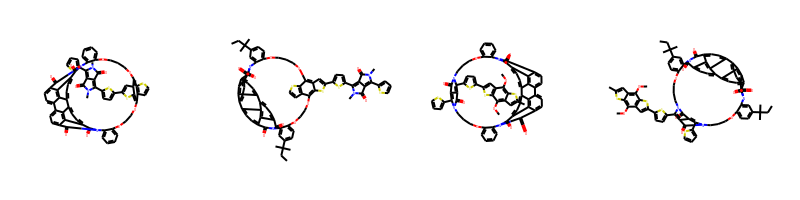

In [1]:
from Gaussain_Dushin_modules import *

#INPUTS ====================================================
input_file = "TS-P"
draw = True
states = [0,1] #initial state, final state
charges = [0,0] #initial charge, final charge


functional_basis = "b3lyp/6-311g(d,p)"
#functional_basis = "CAM-B3LYP/6-311g(d,p)"
#functional_basis = "wB97XD/6-311g(d,p)"
#============================================================

#set once for each user ------------------------------------------------------
hostname = 'login.hpc.ic.ac.uk'

username = 'gs920'
password= "Illusions9"

#username = 'ma11115'
#password = 'Baha140821'

project_folder_name = "Stage2/"
#project_folder_name = "george_project/"

#-----------------------------------------------------------------------------



#loading molecules from list
smiles_list = pd.read_csv('/home/inferno/Bsc_Project/chem_structures/'+input_file+".csv")

#converting
input_structures = [Chem.MolFromSmiles(x) for x in smiles_list["smiles string"]]
input_visual=Draw.MolsToGridImage(input_structures,molsPerRow=4,subImgSize=(200,200)) 
pybel_mol_list = pybel_readsmiles(smiles_list["smiles string"], 2000)


mol_list = input_structures
mol_list_name = input_file  #serial for molecule


#folders
#remote
remote_base_folder ="/rds/general/user/"+username+"/home/"
remote_project_folder = remote_base_folder+project_folder_name
remote_bin_path = "PATH="+remote_base_folder+"bin:$PATH"

remote_folder = remote_project_folder+input_file+"/"
remote_dushin_folder = remote_project_folder+"dushin_operations/"

renamed_fb = functional_basis.split("/")[0] + "_" + functional_basis.split("/")[1].split("(")[0]  #renamed functional basis to make it able to be a folder
remote_basis_folder = remote_folder+renamed_fb+"/"

#local
local_folder_base = "../"
xyz_folder = local_folder_base + "Scripts/xyz_files/"
dushin_output_folder = local_folder_base + "Scripts/dushin_outputs/"
sh_output_folder = local_folder_base + "sh_files/"
theodore_run_folder = local_folder_base + "Scripts/Theodore_runs/"

#folders for database
drawing_folder = local_folder_base+"Database/Mol_images/"
dushin_save_folder = local_folder_base+"Database/Reorg_Energy/Stage2/"
dushin_image_save_folder = local_folder_base+"Database/Reorg_Energy/plots/"
gaussian_save_folder = local_folder_base+"Database/Gaussian_outputs/Stage2/"



#drawing molecule for reference
if draw:
    for mol_num in range(0,len(mol_list)):
        Draw.MolToFile(mol_list[mol_num], drawing_folder+mol_list_name+"_"+str(mol_num)+".png")
        
#Basis set settings
norm_functional_basis = "b3lyp/6-311g(d,p)" #the default or "normal" functional basis set


#info about system being ran
print("functional and basis: ", functional_basis)
print("states: ", states)
print("charges: ",charges)

print("mol_list_name: ", mol_list_name)
print("Raw smiles list:")
print(smiles_list)

input_visual

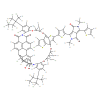

In [3]:
pybel_mol_list[1]

### Manual Upload

In [ ]:
#Manual upload, Aimed for the short queue

for mol_num in range(0,len(mol_list)):
    mol_xyz = generate_XYZgeo_from_mol(mol_list, mol_list_name, mol_num, theodore_run_folder)
    for state_num in range(0,len(states)):
        gjf_file = generate_Gjf_optfreqStates(mol_list, mol_list_name, mol_xyz, mol_num, states[state_num], charges[state_num], output_folder = sh_output_folder)
        generate_shfile_gaussian(output_folder = sh_output_folder, walltime='07:59:00', memory="32gb", ncpus=30, timeout="8h", molnumber= mol_num,
                             Excited_state = states[state_num], mollist_name= mol_list, gjf_file=gjf_file)
        print("Gaussian inputs generated for ",mol_list_name+"_"+str(mol_num))



#### Automatic Upload to HPC

In [102]:
status = "Started"
print("Status = ", status)

#conversion from smiles to gjf

#for mol_num in range(0,len(mol_list)):
for mol_num in [0]:
    
    #mol_xyz, n_atoms = generate_XYZgeo_from_mol(mol_list, mol_list_name, mol_num, os.getcwd()+"/", save=False)
    mol_xyz, n_atoms = pybel_xyz_fromMol(pybel_mol_list, mol_list_name, mol_num, xyz_folder) #experimental feature, using pybel to preoptimize geometry

    for state_num in range(0,len(states)):
        gjf_file = generate_Gjf_optfreqStates(mol_list, mol_list_name, mol_xyz, mol_num, states[state_num], charges[state_num],\
                                              functional_basisset=functional_basis)
        
        if n_atoms < 50 and states[state_num] == 0: #targeted at short queue
            generate_shfile_gaussian(walltime='07:59:00', memory="60gb", ncpus=48, timeout="8h", molnumber= mol_num,\
                                     Excited_state = states[state_num], mollist_name= mol_list, gjf_file=gjf_file)
                
            
        else:            #targeted at medium queue
            generate_shfile_gaussian(walltime='36:00:00', memory="60gb", ncpus=100, timeout="36h", molnumber= mol_num,\
                                     Excited_state = states[state_num], mollist_name= mol_list, gjf_file=gjf_file)
        
        if functional_basis != norm_functional_basis:
            run_job_HPC(hostname = hostname,username = username, password = password, remotefolder = remote_basis_folder,\
                             molnumber = mol_num, Excited_state = states[state_num],mollist_name= mol_list_name, gjf_file= gjf_file)
        else:
            run_job_HPC(hostname = hostname,username = username, password = password, remotefolder = remote_folder,\
                             molnumber = mol_num, Excited_state = states[state_num],mollist_name= mol_list_name, gjf_file= gjf_file)
        

            
        
        print("Queued job for: ",gjf_file)
        os.remove(gjf_file+".gjf")
        os.remove(gjf_file+".sh")
        
print("All Jobs uploaded")  


Status =  Started
Standard error:
b''
Exit status: 0
Queued job for:  IDT_0_C0S0
Standard error:
b''
Exit status: 0
Queued job for:  IDT_0_C1S0
All Jobs uploaded


## Jobs completed
#### Just reading and saving Gaussian

In [101]:
Error_mol_list = []
        
#for mol_num in [1]:
for mol_num in range(0,len(mol_list)):
    try:
        for state_num in range(0,len(states)):
            state = "C" + str(charges[state_num]) + "S" + str(states[state_num])
            
            #transfer gaussian log to local to parse, store useful data, and then delete log file
            mol_serial = mol_list_name+"_"+str(mol_num)+"_"+state
            reading_gaussian_output(hostname, username, password, remote_folder, gaussian_save_folder, mol_serial, functional_basis)
    except Exception as e:
        print(e)
        Error_mol_list.append(mol_serial)


/home/inferno/anaconda3/envs/Bsc_Project/lib/python3.7/site-packages/paramiko/client.py:839: UserWarning: Unknown ssh-ed25519 host key for login.hpc.ic.ac.uk: b'e34c53f357c63885633fb0f904838138'
  key.get_name(), hostname, hexlify(key.get_fingerprint())


Gaussian outputs read and stored for TT_0_C0S0
Gaussian outputs read and stored for TT_1_C0S0


#### Running Dushin and reading Gaussian

/home/inferno/anaconda3/envs/Bsc_Project/lib/python3.7/site-packages/paramiko/client.py:839: UserWarning: Unknown ssh-ed25519 host key for login.hpc.ic.ac.uk: b'e34c53f357c63885633fb0f904838138'
  key.get_name(), hostname, hexlify(key.get_fingerprint())


Gaussian outputs read and stored for IDT_0_C1S0
Gaussian outputs read and stored for IDT_0_C0S0
remote folder = /rds/general/user/gs920/home/Stage2/IDT/
Dushin operating for:  IDT_0   C0S0   C1S0
Standard output:
b'/rds/general/user/gs920/home/Stage2/dushin_operations\n'
Standard error:
b'/rds/general/user/gs920/home/bin/rundushin.sh: line 30: module: command not found\n Nber of molecules processed=           2\n'
Exit status: 0


Gaussian outputs read and stored for IDT_1_C1S0
Dushin error for  IDT_1
[Errno 2] No such file


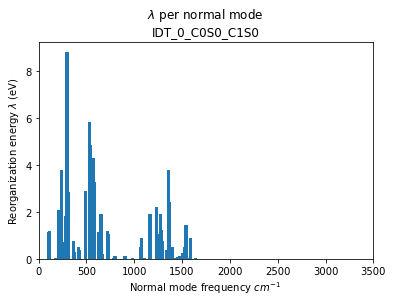

In [101]:
Error_mol_list = []
        
#for mol_num in [0,1]:
for mol_num in range(0,len(mol_list)):
    try:
        for state_num in range(0,len(states),2):
            initial_state = "C" + str(charges[state_num]) + "S" + str(states[state_num])
            final_state = "C" + str(charges[state_num+1]) + "S" + str(states[state_num+1])
            print("\n") #separation of printed output for clarity


            #transfer gaussian log to local to parse, store useful data, and then delete log file
            mol_serial = mol_list_name+"_"+str(mol_num)+"_"+final_state
            reading_gaussian_output(hostname, username, password, remote_folder, gaussian_save_folder, mol_serial, functional_basis)
            
            mol_serial = mol_list_name+"_"+str(mol_num)+"_"+initial_state
            reading_gaussian_output(hostname, username, password, remote_folder, gaussian_save_folder, mol_serial, functional_basis)

            #running and storing dushin
            if functional_basis != norm_functional_basis:
                print("remote folder =", remote_basis_folder)
                run_dushin(hostname, username, password, remote_basis_folder, remote_bin_path, remote_dushin_folder, mol_list, mol_list_name, mol_num, initial_state, final_state)
            
            else:
                print("remote folder =", remote_folder)

                run_dushin(hostname, username, password, remote_folder, remote_bin_path, remote_dushin_folder, mol_list, mol_list_name, mol_num, initial_state, final_state)


            filename = "dushin"+mol_list_name+"_"+str(mol_num)+"_"+initial_state+"_"+final_state+".log"
            transfer_from_HPC(hostname, username, password, dushin_output_folder, remote_dushin_folder, filename)
            reading_graphing_dushin_output(dushin_output_folder, dushin_save_folder, dushin_image_save_folder, filename, functional_basis)
    except Exception as e:
        print("Dushin error for ",mol_list_name+"_"+str(mol_num))
        print(e)
        Error_mol_list.append(mol_list_name+"_"+str(mol_num))
        